In [18]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np

np.random.seed(42)
import functools

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from TMGWO import TMGWO


def load_dataset(dataset):
    data = pd.read_csv(dataset)
    return data


def preprocess(data):
    attributes = data.drop(data.columns[-1], axis=1)
    label = data.columns[-1]
    labelType = data.dtypes[label]
    objectList = attributes.select_dtypes(include="object").columns
    numList = attributes.select_dtypes(include=["int", "float"]).columns
    le = LabelEncoder()
    scaler = MinMaxScaler()
    if labelType == "O":
        data[label] = le.fit_transform(data[label])
    for feature in objectList:
        data[feature] = le.fit_transform(data[feature])
    for feature in numList:
        data[[feature]] = scaler.fit_transform(data[[feature]])
    # joblib.dump(scaler, "models/scaler.pkl")
    return data


def save_preprocessed(preprocessed):
    preprocessed.to_csv("datasets/diabetes_preprocessed.csv", index=False)


def split_preprocessed(preprocessed):
    X = preprocessed[preprocessed.columns[:-1]].values
    y = preprocessed[preprocessed.columns[-1]].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42, test_size=0.2, shuffle=True, stratify=y
    )
    return X, y, X_train, X_test, y_train, y_test


def fitness(x, X_train, y_train, X_test, y_test):
    if x.ndim == 1:
        x = x.reshape(1, -1)
    loss = np.zeros(x.shape[0])
    model = KNeighborsClassifier(metric="jaccard", n_neighbors=2)
    for i in range(x.shape[0]):
        if np.sum(x[i, :]) > 0:
            model.fit(X_train[:, x[i, :].astype(bool)], y_train)
            score = accuracy_score(
                model.predict(X_test[:, x[i, :].astype(bool)]), y_test
            )
            loss[i] = 0.99 * (1 - score) + 0.01 * (np.sum(x[i, :]) / X_train.shape[1])
        else:
            loss[i] = np.inf
    return loss


def data_antar_kelas(y_train):
    positive = list(y_train).count(1)
    negative = list(y_train).count(0)
    fig = plt.figure()
    plt.title("Data antar kelas pada training data")
    plt.bar("Positive", positive)
    plt.annotate(positive, (0, positive / 2), ha="center")
    plt.bar("Negative", negative)
    plt.annotate(negative, (1, negative / 2), ha="center")
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah data")
    plt.show()
    return fig


def feature_selection(X_train, X_test, y_train, y_test):
    lossfunc = functools.partial(
        fitness, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
    )
    optimizer = TMGWO(fitness=lossfunc, D=X_train.shape[1], P=8, G=70)
    optimizer.optimize()
    selected_features = optimizer.gBest_X > 0
    return selected_features


def plot_selected_features(X, selected_features):
    fig = plt.figure()
    plt.title("Jumlah Fitur Sebelum dan Sesudah Seleksi Fitur")
    plt.bar("before", X.shape[1])
    plt.annotate(X.shape[1], (0, X.shape[1] / 2), ha="center")
    plt.bar("after", X[:, selected_features].shape[1])
    plt.annotate(
        X[:, selected_features].shape[1],
        (1, X[:, selected_features].shape[1] / 2),
        ha="center",
    )
    plt.ylabel("Num of features")
    return fig


def do_smote(X_train, y_train):
    try:
        smote = SMOTENC(
            random_state=42,
            categorical_features=[
                False,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
                True,
            ],
            k_neighbors=5,
        )
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    except:
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote


def plot_smote(y_train_smote):
    positive = list(y_train_smote).count(1)
    negative = list(y_train_smote).count(0)
    fig = plt.figure()
    plt.title("Data antar kelas pada training data setelah SMOTE")
    plt.bar("Positive", height=positive)
    plt.annotate(positive, (0, positive / 2), ha="center", fontsize=20)
    plt.bar("Negative", height=negative)
    plt.annotate(negative, (1, negative / 2), ha="center", fontsize=20)
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah data")
    return fig





def split_for_crossval(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42, test_size=0.2, stratify=y, shuffle=True
    )
    return X_train, y_train


hasil = {}
hasil["akurasi"] = {}
hasil["cm"] = {}
hasil["cr"] = {}
hasil["cross_val"] = {}
hasil["cross_val"]["num_sf"] = []
hasil["cross_val"]["akurasi"] = {}
hasil["cross_val"]["cm"] = {}
hasil["cross_val"]["cr"] = {}


def cross_val(X, y, algoritma):
    hasil["cross_val"]["akurasi"][algoritma] = []
    hasil["cross_val"]["cm"][algoritma] = []
    hasil["cross_val"]["cr"][algoritma] = []
    X_train, y_train = split_for_crossval(X, y)
    skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    for train, test in skf.split(X_train, y_train):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        if algoritma == "KNN+SMOTE+TMGWO":
            selected_features = feature_selection(X_train, X_test, y_train, y_test)
        if algoritma == "KNN+SMOTE" or algoritma == "KNN+SMOTE+TMGWO":
            X_train, y_train = do_smote(X_train, y_train)
        model = KNeighborsClassifier(metric="jaccard", n_neighbors=5)
        if algoritma == "KNN+SMOTE+TMGWO":
            X_train = X_train[:, selected_features]
            X_test = X_test[:, selected_features]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        hasil["cross_val"]["akurasi"][algoritma].append(
            float("{:.2f}".format(accuracy_score(y_test, y_pred) * 100))
        )
        hasil["cross_val"]["cm"][algoritma].append(confusion_matrix(y_test, y_pred))
        hasil["cross_val"]["cr"][algoritma].append(
            classification_report(
                y_test, y_pred, output_dict=True, target_names=["Negative", "Positive"]
            )
        )
        if algoritma == "KNN+SMOTE+TMGWO":
            hasil["cross_val"]["num_sf"].append(list(selected_features).count(True))


def train_model(X, y, X_train, X_test, y_train, y_test, algoritma, cv=False):
    if cv:
        cross_val(X, y, algoritma)
    model = KNeighborsClassifier(metric="jaccard", n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    hasil["akurasi"][algoritma] = float(
        "{:.2f}".format(accuracy_score(y_test, y_pred) * 100)
    )
    hasil["cm"][algoritma] = confusion_matrix(y_test, y_pred)
    hasil["cr"][algoritma] = classification_report(
        y_test, y_pred, output_dict=True, target_names=["Negative", "Positive"]
    )
    score = hasil["akurasi"][algoritma]
    cm = hasil["cm"][algoritma]
    cr = hasil["cr"][algoritma]
    # joblib.dump(model, f"models/{algoritma}.pkl")
    return model, score, cm, cr


def get_highest_acc_index(hasil):
    index = {}
    for key, val in hasil["akurasi"].items():
        index[key] = val.index(max(val))
    return index


def plot_cm(cm, algo):
    fig, ax = plt.subplots()
    cm = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
    cm.plot(ax=ax)
    plt.title(f"Confusion Matrix {algo}")
    return fig


def plot_highest_accuracy(hasil):
    fig = plt.figure()
    acc = [acc for acc in hasil["akurasi"].values()]
    label = [algoritma for algoritma in hasil["akurasi"].keys()]
    juml = len(acc)
    plt.title("Hasil Model")
    for i in range(juml):
        plt.bar(i, acc[i], label="Ori")
        plt.annotate(f"{acc[i]} %", (i, acc[i] / 2), ha="center")
    plt.ylabel("Akurasi")
    plt.xticks([i for i in range(juml)], label)
    plt.xlabel("Algoritma")
    plt.ylim(0, 100)
    return fig


In [19]:
data = load_dataset("../datasets/diabetes.csv")

In [20]:
data.sample(20)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
275,72,Male,Yes,No,No,No,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Negative
93,40,Female,Yes,Yes,No,Yes,Yes,No,No,Yes,No,No,Yes,No,No,No,Positive
6,57,Male,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,No,No,Positive
167,41,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Positive
90,45,Female,No,No,No,No,Yes,No,Yes,Yes,No,No,Yes,No,No,No,Positive
513,62,Female,Yes,Yes,Yes,Yes,No,No,Yes,No,No,No,Yes,No,No,Yes,Positive
362,28,Female,No,No,No,No,No,No,Yes,No,No,No,Yes,Yes,No,No,Positive
228,45,Male,No,No,No,Yes,No,No,No,Yes,Yes,Yes,Yes,No,No,No,Negative
192,64,Male,No,Yes,No,No,No,No,No,No,Yes,Yes,No,No,No,No,Positive
482,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative


In [21]:
np.random.seed(42)

preprocessed_data = preprocess(data)

In [22]:
preprocessed_data.sample(20)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
275,0.756757,1,1,0,0,0,1,0,1,1,0,1,1,1,1,0,0
93,0.324324,0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,1
6,0.554054,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1
167,0.337838,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1
90,0.391892,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1
513,0.621622,0,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1
362,0.162162,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
228,0.391892,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0
192,0.648649,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
482,0.351351,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [23]:
np.random.seed(42)

X, y, X_train, X_test, y_train, y_test = split_preprocessed(preprocessed_data)

In [24]:
np.random.seed(42)

selected_features = feature_selection(X_train, X_test, y_train, y_test)

In [25]:
np.random.seed(42)

print("List of selected features: ")
for idx, feature in enumerate(list(data.columns[np.where(selected_features)]), start=1):
    print(f"{idx}. {feature}")

List of selected features: 
1. Polyuria
2. Polydipsia
3. sudden weight loss
4. visual blurring
5. Irritability
6. delayed healing
7. partial paresis
8. muscle stiffness
9. Alopecia
10. Obesity


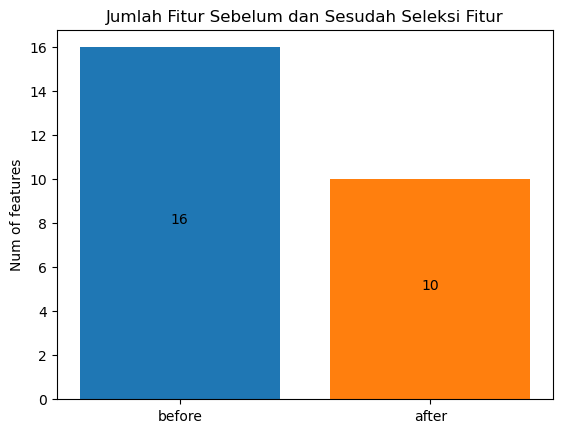

In [26]:
plot_selected_features(X, selected_features).show()

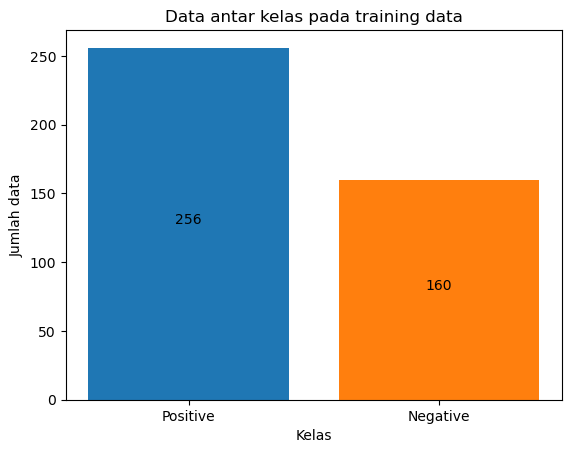

In [27]:
data_antar_kelas(y_train).show()

In [28]:
X_train_smote, y_train_smote = do_smote(X_train, y_train)

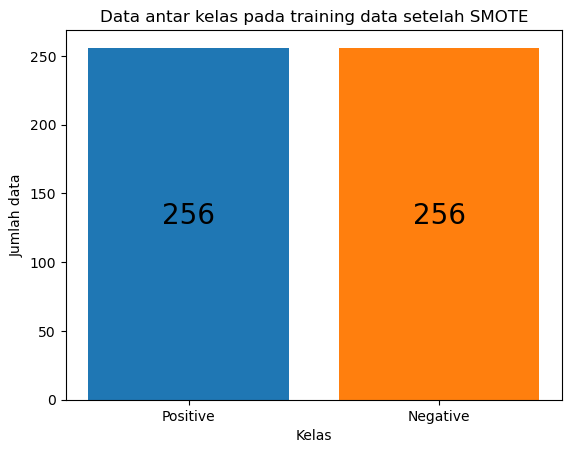

In [29]:
plot_smote(y_train_smote).show()

In [30]:
np.random.seed(42)

model_knn, score_knn, cm_knn, cr_knn = train_model(X, y, X_train, X_test, y_train, y_test, "KNN", True)
model_knn_smote, scor_knn_smotee, cm_knn_smote, cr_knn_smote = train_model(X, y, X_train_smote, X_test, y_train_smote, y_test, "KNN+SMOTE", True)
model_knn_smote_tmgwo, score_knn_smote_tmgwo, cm_knn_smote_tmgwo, cr_knn_smote_tmgwo = train_model(X, y, X_train_smote[:, selected_features], X_test[:, selected_features], y_train_smote, y_test, "KNN+SMOTE+TMGWO", True)

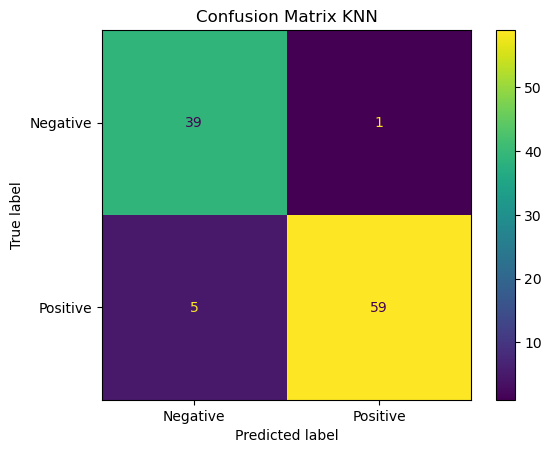

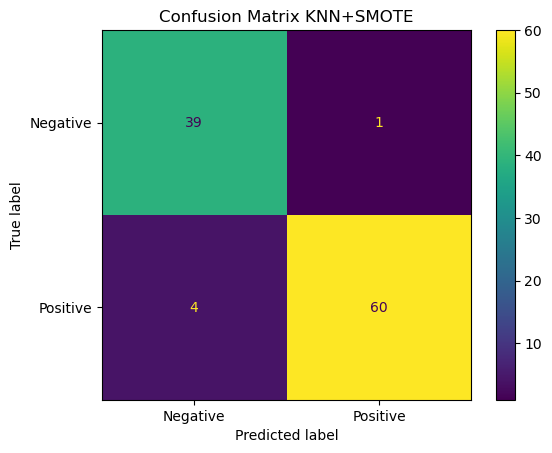

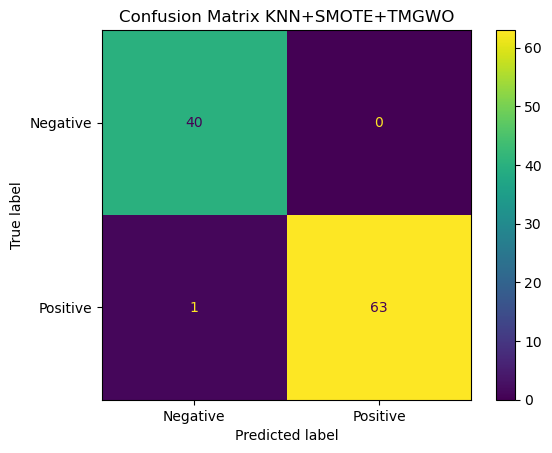

In [31]:
for algorithm in hasil["cm"].keys():
    plot_cm(hasil["cm"][algorithm], algorithm).show()

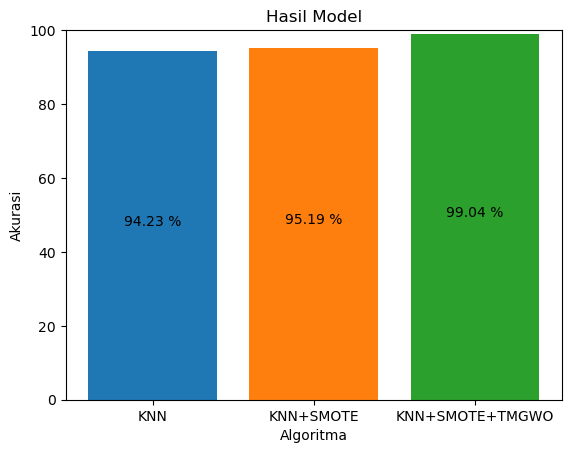

In [32]:
plot_highest_accuracy(hasil).show()

In [33]:
for algorithm in hasil['cr'].keys():
    print(f"Classification Report {algorithm}".center(60, '-'))
    print()
    print(pd.DataFrame(hasil['cr'][algorithm]).T)
    print()

-----------------Classification Report KNN------------------

              precision    recall  f1-score     support
Negative       0.886364  0.975000  0.928571   40.000000
Positive       0.983333  0.921875  0.951613   64.000000
accuracy       0.942308  0.942308  0.942308    0.942308
macro avg      0.934848  0.948438  0.940092  104.000000
weighted avg   0.946037  0.942308  0.942751  104.000000

--------------Classification Report KNN+SMOTE---------------

              precision    recall  f1-score     support
Negative       0.906977  0.975000  0.939759   40.000000
Positive       0.983607  0.937500  0.960000   64.000000
accuracy       0.951923  0.951923  0.951923    0.951923
macro avg      0.945292  0.956250  0.949880  104.000000
weighted avg   0.954134  0.951923  0.952215  104.000000

-----------Classification Report KNN+SMOTE+TMGWO------------

              precision    recall  f1-score     support
Negative       0.975610  1.000000  0.987654   40.000000
Positive       1.000000  0.9

In [34]:
from tabulate import tabulate
for key, val in hasil['cross_val']['akurasi'].items():
    print(key.center(70, '='))
    print(tabulate([val], headers=[str(i) for i in range(1,11)]))
    print()
    print("rata-rata: ", np.mean(val))
    print("+"*70)

=================================KNN==================================
    1      2      3      4     5      6      7      8     9     10
-----  -----  -----  -----  ----  -----  -----  -----  ----  -----
95.24  92.86  95.24  90.48  88.1  95.24  92.68  97.56  87.8  90.24

rata-rata:  92.544
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
==============================KNN+SMOTE===============================
    1     2      3      4     5      6      7      8     9    10
-----  ----  -----  -----  ----  -----  -----  -----  ----  ----
97.62  88.1  90.48  92.86  88.1  95.24  92.68  95.12  87.8  87.8

rata-rata:  91.58
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
===========================KNN+SMOTE+TMGWO============================
    1      2      3      4      5    6      7      8      9     10
-----  -----  -----  -----  -----  ---  -----  -----  -----  -----
90.48  95.24  92.86  97.62  97.62  100  90.24  95.12  92.68  90.24

rata-rat